In [154]:
import pandas as pd
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier, XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Wrangle

In [138]:
def wrangle(filepath):
    df = pd.read_csv(filepath,
                index_col='id',
                parse_dates=['last_review'])

    
    subways = pd.read_csv('nearsubway.csv').drop(['short_name', 'long_name'], axis=1)
    subways2 = subways['Community District'].str.split('/').explode()
    subways3 = pd.merge(subways2, subways, left_index=True, right_index=True).drop('Community District_y',axis=1)
    subdict = {'Clinton': 'Clinton Hill',
       'Bedford Stuyvesant': "Bedford-Stuyvesant",
       'Central Harlem': 'Harlem',
       'Soho': 'SoHo'}
    subways3 = subways3.replace(to_replace= subdict)
    x = pd.DataFrame([["Hell's Kitchen", 0.94389], ['East Village', 0.855089], ['West Village', 1.0],
                      ['Long Island City', 0.892801], ['Prospect-Lefferts Gardens', 0.904834],
                      ['Murray Hill', 0.949928], ['Kips Bay', 0.949928],['Gramercy', 0.949928]],
                     columns=['Community District_x', '2017'])
    subways3 = subways3.append(x, ignore_index=True)
    df = pd.merge(df, subways3, left_on='neighbourhood', right_on='Community District_x', how='left').drop('Community District_x',
                                                                                                          axis=1)
    df['reviews_per_listing'] = df['number_of_reviews'] / df['calculated_host_listings_count']
    df['longterm'] = df['minimum_nights'].apply(lambda x:1 if x > 14 else 0)
    df['reviews_per_month'].fillna(0, inplace=True)
    df['last_review'].fillna(datetime.date.today(), inplace=True)
    df['last_review'] = pd.to_datetime(df['last_review']).dt.date
    
    neighb = pd.read_csv('housingcsv.csv')
    df = pd.merge(df, neighb, left_on='neighbourhood', right_on='area', how='left')
    irdict = {'Brooklyn': 6.4, "Manhattan": 8.9}
    hudict = {'Brooklyn': 1053670 / 18, "Manhattan": 886282/ 12}
    df['income diversity ratio'] = df['income diversity ratio'].fillna(df['neighbourhood_group'].map(irdict))
    df['housing units'] = df['housing units'].fillna(df['neighbourhood_group'].map(hudict))
    
    df['housing_units'] = df['housing units']
    df['income_ratio'] = df['income diversity ratio']
    
    na_dict = {'Brooklyn': 79.7,'Bronx': 77.3, 'Manhattan': 96.8, 'Queens': 52.0, 'Staten Island': 21.4}
    df['2017'] = df['2017'].fillna(df['neighbourhood_group'].map(na_dict))
    df.rename({'2017': 'percent_near_subway'}, axis=1, inplace=True)
    df = df[df['room_type'] != 'Shared room']
    df = df[df['neighbourhood_group'].isin(['Manhattan', 'Brooklyn'])]
    df['is_manhattan'] = df['neighbourhood_group'].apply(lambda x:1 if x == 'Manhattan' else 0)
    df['is_brooklyn'] = df['neighbourhood_group'].apply(lambda x:1 if x == 'Brooklyn' else 0)
    df.drop(['name', 'host_name', 'last_review', 'neighbourhood_group', 'area',
            'income diversity ratio', 'housing units'], axis=1, inplace=True)
    return df

In [139]:
df = wrangle('AB_NYC_2019.csv')

# Baseline

In [159]:
dirtydf = pd.read_csv('AB_NYC_2019.csv',
                index_col='id',
                parse_dates=['last_review'])

In [160]:
dirtydf.dropna(inplace=True, axis=0)
dirtydf.drop(['host_name', 'name', 'last_review'], axis=1, inplace=True)
target = 'price'
Xd= dirtydf.drop(target, axis=1)
yd = dirtydf[target]

In [161]:
Xd_train, Xd_val, yd_train, yd_val = train_test_split(Xd, yd, test_size=.3, random_state=54)

In [168]:
linregd = Pipeline(steps=[
    ('enc', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
]);
linregd.fit(Xd_train, yd_train);

In [169]:
linregdpred = (linregd.predict(Xd_val)[:, np.newaxis])
print('base training:', linregd.score(Xd_train, yd_train))
print('base val:', linreg.score(Xd_val, yd_val))
linregdmse = mean_squared_error(yd_val, linregdpred)
linregdmae = mean_absolute_error(yd_val, linregdpred)
print('base mse:', linregdmse)
print('base mae:', linregdmae)

base training: 0.1023793737284564
base val: 0.11722447870494423
base mse: 31602.386988554113
base mae: 63.86391352413782


In [170]:
dirtypred = linregd.predict(Xd)

In [72]:
fig = px.scatter(x= yd, y= dirtypred, labels={'x': 'True Value', 'y': 'Prediction'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=yd.min(), y0=yd.min(),
    x1=yd.max(), y1=yd.max()
)

fig.show()

# Models

In [73]:
target = 'price'
X= df.drop(target, axis=1)
y = df[target]

In [74]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=54)

In [75]:
# Linreg
linreg = Pipeline(steps=[
    ('enc', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
]);
linreg.fit(X_train, y_train);

In [96]:
linregpred = (linreg.predict(X)[:, np.newaxis])
print('linreg training:', linreg.score(X_train, y_train))
print('linreg val:', linreg.score(X_val, y_val))
linregmse = mean_squared_error(y, linregpred)
linregmae = mean_absolute_error(y, linregpred)
print('linreg mse:', linregmse)
print('linreg mae:', linregmae)

linreg training: 0.09452500898049476
linreg val: 0.1304066533875079
linreg mse: 56717.782746332996
linreg mae: 78.54749605617874


In [78]:
# Linreg w poly
linregpoly = Pipeline(steps=[
    ('enc', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(2)),
    ('regressor', LinearRegression(n_jobs=-1))
]);
linregpoly.fit(X_train, y_train);

In [95]:
linregpolypred = (linregpoly.predict(X)[:, np.newaxis])
print('linreg w/ poly training:', linregpoly.score(X_train, y_train))
print('linreg w/ poly val:', linregpoly.score(X_val, y_val))
linregpmse = mean_squared_error(y, linregpolypred)
linregpmae = mean_absolute_error(y, linregpolypred)
print('linreg w poly mse:', linregpmse)
print('linreg w poly mae:', linregpmae)

linreg w/ poly training: 0.1241331172654272
linreg w/ poly val: 0.1328469607735322
linreg w poly mse: 55224.166922275326
linreg w poly mae: 76.31143561549547


In [80]:
# ridge
ridge = Pipeline(steps=[
    ('enc', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=2.5,
                       max_iter=500))]);
ridge.fit(X_train, y_train);

In [94]:
ridgepred = (ridge.predict(X)[:, np.newaxis])
print('ridge training:', ridge.score(X_train, y_train))
print('ridge val:', ridge.score(X_val, y_val))
ridgemse = mean_squared_error(y, ridgepred)
ridgemae = mean_absolute_error(y, ridgepred)
print('ridge mse:', ridgemse)
print('ridge mae:', ridgemae)

ridge training: 0.0945250083011675
ridge val: 0.1304074577643093
ridge mse: 56717.77160907076
ridge mae: 78.54608742597327


In [82]:
#ridge poly
ridgepoly = Pipeline(steps=[
    ('enc', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(2)),
    ('regressor', Ridge(alpha=2.5))
]);
ridgepoly.fit(X_train, y_train);

In [93]:
ridgepolypred = (ridgepoly.predict(X)[:, np.newaxis])
print('ridgepoly training:', ridgepoly.score(X_train, y_train))
print('ridgepoly val:', ridgepoly.score(X_val, y_val))
ridgepolymse = mean_squared_error(y, ridgepolypred)
ridgepolymae = mean_absolute_error(y, ridgepolypred)
print('ridgepoly mse:', ridgepolymse)
print('ridgepoly mae:', ridgepolymae)

ridgepoly training: 0.12406018948652564
ridgepoly val: 0.1327247324994002
ridgepoly mse: 55229.459816867966
ridgepoly mae: 76.28849288784936


In [84]:
# rf regressor
rf = Pipeline(steps=[
    ('enc', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=12, n_jobs=-1,
                                        max_depth=75, n_estimators=150,
                                        min_samples_leaf=4))]);
rf.fit(X_train, y_train);

In [92]:
rfpred = (rf.predict(X)[:, np.newaxis])
print('rf training:', rf.score(X_train, y_train))
print('rf val:', rf.score(X_val, y_val))
rfmse = mean_squared_error(y, rfpred)
rfmae = mean_absolute_error(y, rfpred)
print('rf mse:', rfmse)
print('rf mae:', rfmae)

rf training: 0.5086288173081757
rf val: 0.18808424825491832
rf mse: 35500.820443340766
rf mae: 53.1346724462589


In [86]:
# xgb regressor
xgb = Pipeline(steps=[
    ('enc', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(random_state=73, n_jobs=-1, subsample=.75,
                              eta=.02, max_depth=5, n_estimators=500))
]);
xgb.fit(X_train, y_train);

In [109]:
xgbpred = xgb.predict(X)[:, np.newaxis]
print('xgb training:', xgb.score(X_train, y_train))
print('xgb val:', xgb.score(X_val, y_val))
xgbmse = mean_squared_error(y, xgbpred)
xgbmae = mean_absolute_error(y, xgbpred)
print('xgb mse:', xgbmse)
print('xgb mae:', xgbmae)

xgb training: 0.5723574921272706
xgb val: 0.20252812015270927
xgb mse: 32158.30813927433
xgb mae: 64.34694121948051


# Feature Importance

<Figure size 720x648 with 0 Axes>

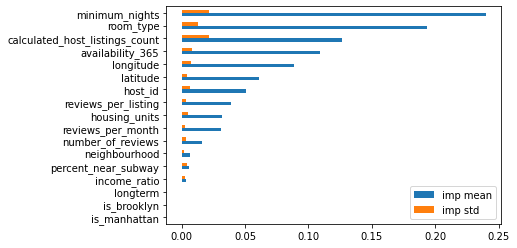

<Figure size 720x648 with 0 Axes>

In [134]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(xgb, X_val, y_val, random_state=12)
data = {'imp mean': perm_imp['importances_mean'],
        'imp std': perm_imp['importances_std']}

pd.DataFrame(data=data, index=X_val.columns).sort_values('imp mean').plot.barh()
n = 18
plt.figure(figsize=(10,n/2))

<AxesSubplot:title={'center':'Linreg Feature Importances'}>

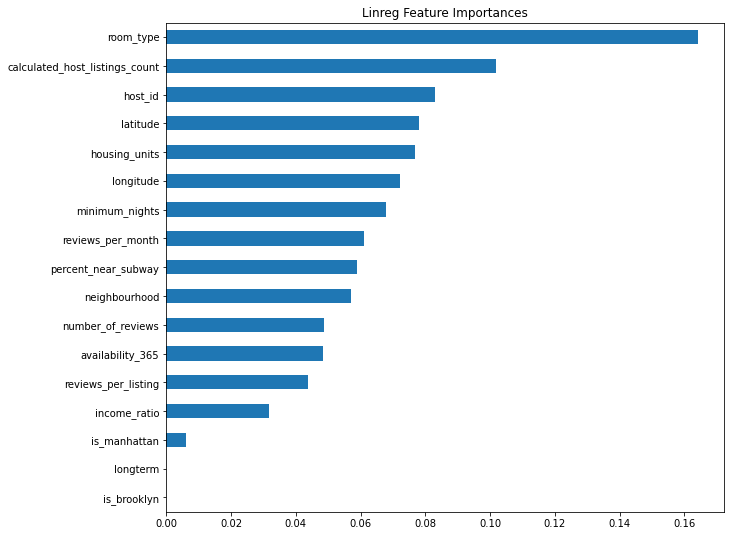

In [137]:
feat_imp = pd.Series(xgb.named_steps['regressor'].feature_importances_, X.columns)
n = 18
plt.figure(figsize=(10,n/2))
plt.title('Linreg Feature Importances')
feat_imp.sort_values()[-n:].plot.barh()

F_regression

In [173]:
from sklearn.feature_selection import f_regression

In [178]:
preprocessing = Pipeline(steps=[
    ('enc', OrdinalEncoder()),
    ('scale', StandardScaler())
]);
preprocessing.fit(X_train, y_train);
XT_train = preprocessing.transform(X_train)
XT_val = preprocessing.transform(X_val)

<AxesSubplot:title={'center':'F_Regression'}>

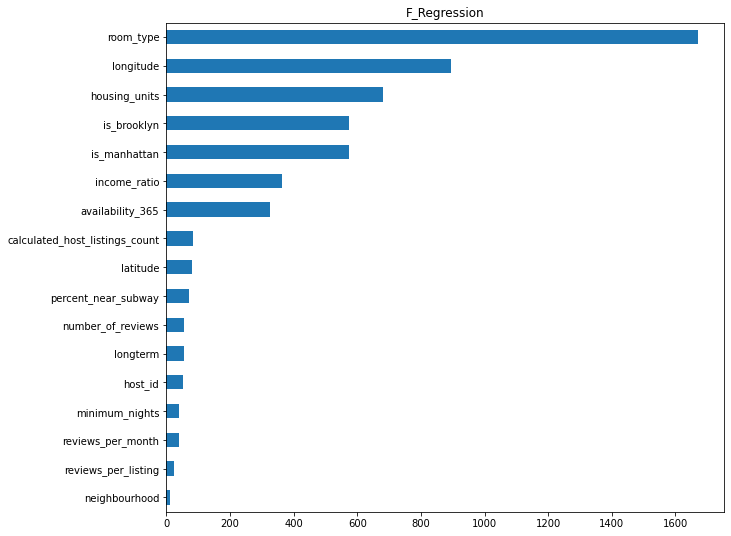

In [184]:
f_reg = pd.Series(f_regression(XT_train, y_train)[0], X.columns)
n = 18
plt.figure(figsize=(10,n/2))
plt.title('F_Regression')
f_reg.sort_values()[-n:].plot.barh()